<h1 class="text-success text-center"> Fraud Detection - Data Exploration/Cleaning</h1>
The data was recoverred from a Kaggle competition: [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud)

<h2> Packages used in this Notebook</h2>

* Pandas:
* Numpy:
* Pickle:
* Matplotlib:
* Tensorflow:
* Keras:
* Scikit-learn:
* Seaborn: For statistical representations

In [200]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, average_precision_score
from sklearn.metrics import recall_score, precision_score

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers, metrics

from scipy.stats import norm

%matplotlib inline

# Setting seaborn configuration for the figures
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

random_seed = 42
labels = ['Normal','Fraud']

<h2>Data Description</h2>
Data recorder during 2 days in September 2013

Dataset <b>highly unbalanced</b>: 492 frauds out of 284807 transactions (0.172% of transactions).

The dataset contains 28 variables which are the result of a PCA transformation. No prior knowledge about the original features (due to confidentiality).

Input variables:
* <b>Features V1,...,V28:</b> Principal components from the PCA transformation.
* <b>Time:</b> Seconds elapsed between each transactions since the first transaction.
* <b>Amount:</b> Transaction amount.
* <b>Class:</b>1 if is a fraud, 0 otherwise.

<b>Recommended metric:</b> Area Under the Precision-Recall Curve (AUPRC)

<h2>Data Exploration</h2>
To access the data, please use the following packages:

* s3fs (boto3 installed by default)

This package allows us to access the data in S3 (axiods directory).

In [2]:
#data = pd.read_csv("s3://axiods/detection_de_fraude/creditcard.csv")
data = pd.read_csv("data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
# To check if there is any missing value in the dataframe
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [10]:
# Analysing the 'TIME' feature of the dataset
print("Fraud transactions:")
print(data.Time[data.Class==1].describe())
print("Normal transactions:")
print(data.Time[data.Class==0].describe())

Fraud transactions:
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64
Normal transactions:
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


Text(0,0.5,'Nb transactions')

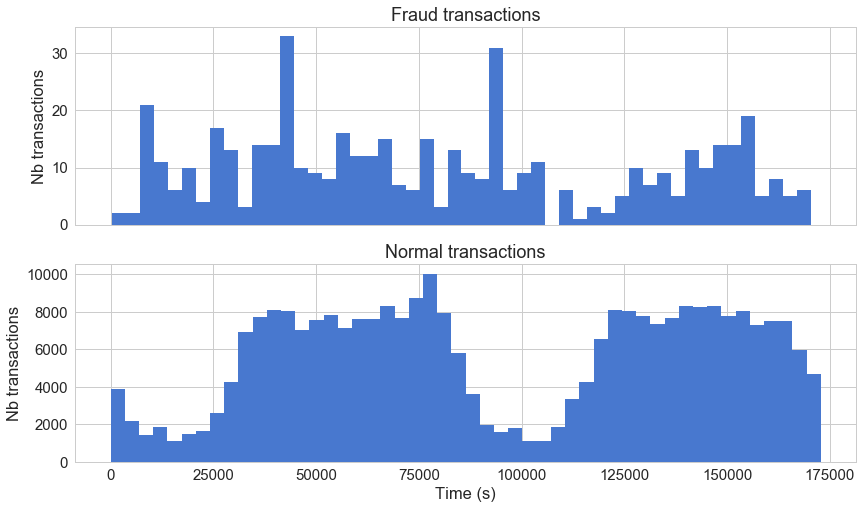

In [12]:
nb_bins = 50
f, ax = plt.subplots(2,1,sharex=True)
ax[0].hist(data.Time[data.Class==1],bins=nb_bins)
ax[0].set_title("Fraud transactions")
ax[0].set_ylabel("Nb transactions")

ax[1].hist(data.Time[data.Class==0],bins=nb_bins)
ax[1].set_title("Normal transactions")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Nb transactions")

In [11]:
# Analysing the 'AMOUNT' feature of the dataset
print("Fraud transactions:")
print(data.Amount[data.Class==1].describe())
print("Normal transactions:")
print(data.Amount[data.Class==0].describe())

Fraud transactions:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
Normal transactions:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


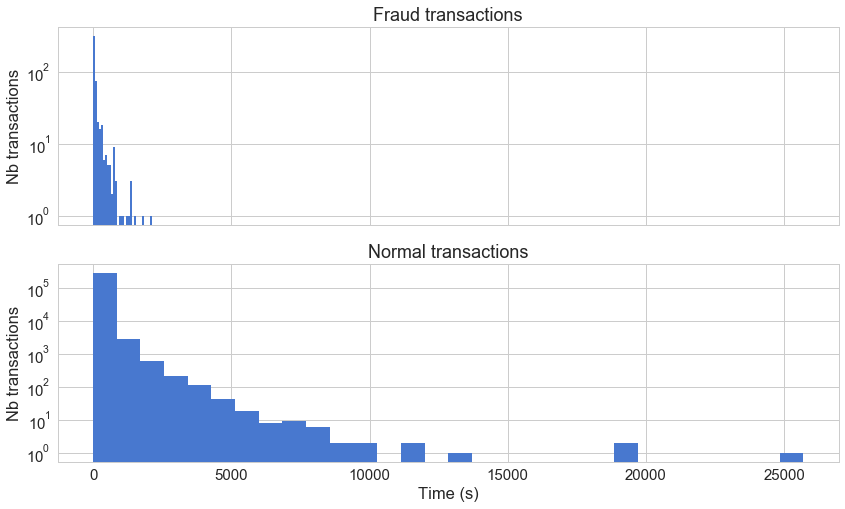

In [13]:
nb_bins = 30
f, ax = plt.subplots(2,1,sharex=True)
ax[0].hist(data.Amount[data.Class==1],bins=nb_bins)
ax[0].set_title("Fraud transactions")
ax[0].set_ylabel("Nb transactions")
ax[0].set_yscale('log')

ax[1].hist(data.Amount[data.Class==0],bins=nb_bins)
ax[1].set_title("Normal transactions")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Nb transactions")
ax[1].set_yscale('log') # Only for visualization purposes

<b>Analysing the relationship between TIME and AMOUNT</b>

Text(0.5,0,'Time (in seconds)')

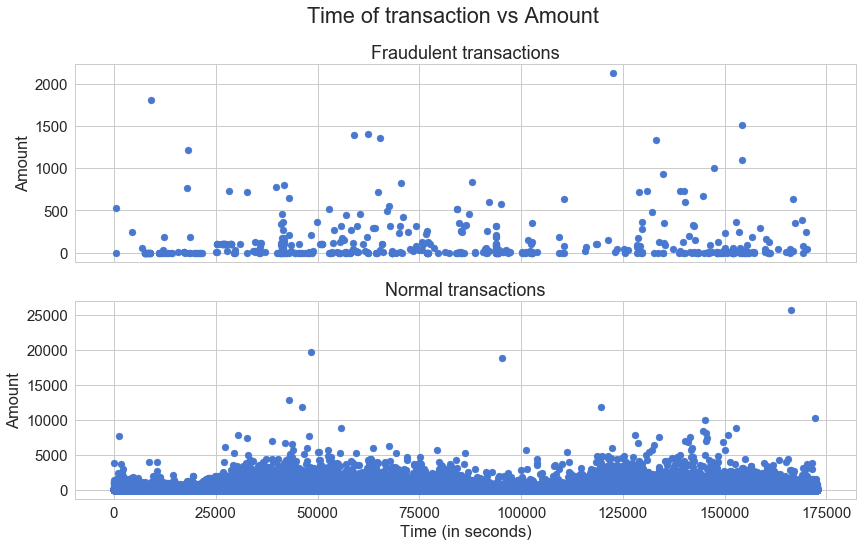

In [17]:
f, ax = plt.subplots(2,1,sharex=True)
f.suptitle('Time of transaction vs Amount')

ax[0].scatter(data.Time[data.Class==1],data.Amount[data.Class==1])
ax[0].set_title('Fraudulent transactions')
ax[0].set_ylabel('Amount')

ax[1].scatter(data.Time[data.Class==0],data.Amount[data.Class==0])
ax[1].set_title('Normal transactions')
ax[1].set_ylabel('Amount')
ax[1].set_xlabel('Time (in seconds)')

There is <b>NO VISUAL RELATIONSHIP/PATTERN</b> between the amount and the time in the dataset.

<h2>Implementing an Undercomplete Autoencoder</h2>

An [autoencoder](https://www.youtube.com/watch?v=FzS3tMl4Nsc&index=44&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH) is a Neural Network for <b>Unsupervised Learning</b>. The advantage of unsupervised learning is to:

* Automatically extract meaningful features from the data.
* Leverage the availability of unlabeled data.
* Add a data-dependent regularizer to trainings.

Common <b>Loss function</b> to minimize: Squared Error

<b>NOTE:</b> Other neural networks used in Unsupervised Learning are: <b>Restricted Boltzmann Machines</b> and <b>Sparse Coding Models</b>.

<b>Preparing the data:</b>
* Dropping the 'Time' column from the dataset
* Standardize features by removing the mean and scaling to unit variance
* Dividing the dataset in X and Y groups. X has all the features except Class, and Y has only the Class column.

In [100]:
# Dropping 'Time'
X = data.drop(['Time','Class'],axis=1)
Y = data.Class

# Standardising features
X = StandardScaler().fit_transform(X)

X_normal = X[data.Class == 0]
X_fraud  = X[data.Class == 1]

Y_normal = Y[data.Class == 0]
Y_fraud = Y[data.Class == 1]

print("X shape:",np.shape(X))
print("Y shape:",np.shape(Y))
print("X_normal shape:",np.shape(X_normal))
print("X_fraud shape:",np.shape(X_fraud))

X shape: (284807, 29)
Y shape: (284807,)
X_normal shape: (284315, 29)
X_fraud shape: (492, 29)


In [101]:
X_normal_train, X_normal_test, Y_normal_train, Y_normal_test = train_test_split(X_normal,Y_normal,test_size=0.2)
X_fraud_test, X_fraud_val, Y_fraud_test, Y_fraud_val = train_test_split(X_fraud,Y_fraud,test_size=0.5)

# Only normal cases for the VAL SET
X_train, X_val = train_test_split(X_normal_train,test_size=0.125)

#X_test = np.concatenate([X_normal_test,X_fraud_test],axis=0)
X_test = np.concatenate([X_normal_test,X_fraud],axis=0)
Y_test = np.concatenate([Y_normal_test,Y_fraud],axis=0)

print("X fraud test shape:",np.shape(X_fraud_test))
print("X normal test shape:",np.shape(X_normal_test))
print("X train shape:",np.shape(X_train))
print("X val shape:",np.shape(X_val))
print("X test shape",np.shape(X_test))

X fraud test shape: (246, 29)
X normal test shape: (56863, 29)
X train shape: (199020, 29)
X val shape: (28432, 29)
X test shape (57355, 29)


<h2>Building the model</h2>
Using a MLP network with 4 full connected layers: 2 for the encoder and 2 for the decoder, plus a L1 regularization.

In [214]:
input_dim = X_train.shape[1]
encoder_l1 = int(input_dim*0.5)
encoder_l2 = int(encoder_l1*0.5)

decoder_l1 = int(encoder_l2*2)
decoder_l2 = input_dim

<b>NOTE:</b> The order of the activation functions in the decoder are not the same as in the encoder.

In [223]:
def get_autoencoder_model():
    # Building the model
    inputs = Input(shape=(input_dim,))

    # ENCODER layers
    encoder = Dense(units=encoder_l1, activation="tanh",
                    activity_regularizer=regularizers.l1(10e-5))(inputs)
    encoder = Dense(units=encoder_l2, activation="relu")(encoder)

    # DECODER layers
    decoder = Dense(units=decoder_l1, activation="tanh")(encoder)
    decoder = Dense(units=decoder_l2, activation="relu")(decoder)

    # Defining the AUTOENCODER
    autoencoder = Model(inputs=inputs, output=decoder)

    # Compiling the model
    autoencoder.compile(optimizer='Adam',loss='mean_squared_error',
                       metrics=['accuracy'])
    
    return autoencoder

def get_autoencoder_model1():
    # Building the model
    inputs = Input(shape=(input_dim,))

    # ENCODER layers
    encoder = Dense(units=14, activation="tanh",
                    activity_regularizer=regularizers.l1(10e-5))(inputs)
    encoder = Dense(units=14, activation="relu")(encoder)
    encoder = Dense(units=7, activation="relu")(encoder)

    # DECODER layers
    decoder = Dense(units=7, activation="tanh")(encoder)
    decoder = Dense(units=14, activation="relu")(decoder)
    decoder = Dense(units=29, activation="relu")(decoder)

    # Defining the AUTOENCODER
    autoencoder = Model(inputs=inputs, output=decoder)

    # Compiling the model
    autoencoder.compile(optimizer='Adam',loss='mean_squared_error',
                       metrics=['accuracy'])
    
    return autoencoder

In [224]:
# TRAINING process
nb_epochs = 500
batch_size = 2048

autoencoder  = get_autoencoder_model()
autoencoder1 = get_autoencoder_model1()

# Autoencoder: Defining checkpoints
bestModelFile = 'autoencoder_5.h5'
checkpoint = ModelCheckpoint(filepath=bestModelFile,verbose=1,
                             monitor='val_loss',mode='min',
                             save_best_only=True)

history = autoencoder.fit(X_train,X_train,epochs=nb_epochs,
                          batch_size=batch_size,shuffle=True,
                          validation_data=(X_val,X_val),verbose=1,
                          callbacks=[checkpoint])

# Autoencoder1: Defining checkpoints
bestModelFile1 = 'autoencoder_6.h5'
checkpoint = ModelCheckpoint(filepath=bestModelFile1,verbose=1,
                             monitor='val_loss',mode='min',
                             save_best_only=True)

history1 = autoencoder1.fit(X_train,X_train,epochs=nb_epochs,
                          batch_size=batch_size,shuffle=True,
                          validation_data=(X_val,X_val),verbose=1,
                          callbacks=[checkpoint])



/Users/jeancupe/ddf_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app
/Users/jeancupe/ddf_env/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 199020 samples, validate on 28432 samples
Epoch 1/500
182272/199020 [==========================>...] - ETA: 0s - loss: 2.3310 - acc: 0.0470
Epoch 00001: val_loss improved from inf to 2.08672, saving model to autoencoder_5.h5
199020/199020 [==============================] - 4s 22us/step - loss: 2.3082 - acc: 0.0522 - val_loss: 2.0867 - val_acc: 0.1061
Epoch 2/500
184320/199020 [==========================>...] - ETA: 0s - loss: 1.7704 - acc: 0.1172
Epoch 00002: val_loss improved from 2.08672 to 1.45279, saving model to autoencoder_5.h5
199020/199020 [==============================] - 1s 3us/step - loss: 1.7451 - acc: 0.1182 - val_loss: 1.4528 - val_acc: 0.1243
Epoch 3/500
184320/199020 [==========================>...] - ETA: 0s - loss: 1.1458 - acc: 0.1226
Epoch 00003: val_loss improved from 1.45279 to 1.01711, saving model to autoencoder_5.h5
199020/199020 [==============================] - 1s 3us/step - loss: 1.1324 - acc: 0.1193 - val_loss: 1.0171 - val_acc: 0.0765
Epoch 4/50

188416/199020 [===========================>..] - ETA: 0s - loss: 0.7950 - acc: 0.2889
Epoch 00027: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7932 - acc: 0.2890 - val_loss: 0.8409 - val_acc: 0.2835
Epoch 28/500
190464/199020 [===========================>..] - ETA: 0s - loss: 0.7950 - acc: 0.2893
Epoch 00028: val_loss improved from 0.84084 to 0.83886, saving model to autoencoder_5.h5
199020/199020 [==============================] - 1s 3us/step - loss: 0.7930 - acc: 0.2892 - val_loss: 0.8389 - val_acc: 0.2912
Epoch 29/500
192512/199020 [============================>.] - ETA: 0s - loss: 0.7931 - acc: 0.2903
Epoch 00029: val_loss improved from 0.83886 to 0.83820, saving model to autoencoder_5.h5
199020/199020 [==============================] - 1s 4us/step - loss: 0.7918 - acc: 0.2900 - val_loss: 0.8382 - val_acc: 0.2921
Epoch 30/500
194560/199020 [============================>.] - ETA: 0s - loss: 0.7920 - acc: 0.2909
Epoch 00030: val_los

199020/199020 [==============================] - 1s 3us/step - loss: 0.7715 - acc: 0.3343 - val_loss: 0.8145 - val_acc: 0.3302
Epoch 55/500
190464/199020 [===========================>..] - ETA: 0s - loss: 0.7702 - acc: 0.3351
Epoch 00055: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7715 - acc: 0.3353 - val_loss: 0.8163 - val_acc: 0.3335
Epoch 56/500
198656/199020 [============================>.] - ETA: 0s - loss: 0.7701 - acc: 0.3365
Epoch 00056: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7700 - acc: 0.3365 - val_loss: 0.8146 - val_acc: 0.3245
Epoch 57/500
190464/199020 [===========================>..] - ETA: 0s - loss: 0.7688 - acc: 0.3375
Epoch 00057: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7695 - acc: 0.3374 - val_loss: 0.8162 - val_acc: 0.3360
Epoch 58/500
194560/199020 [============================>.] - ETA: 0s - loss: 0.7

Epoch 83/500
196608/199020 [============================>.] - ETA: 0s - loss: 0.7464 - acc: 0.3774
Epoch 00083: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7460 - acc: 0.3773 - val_loss: 0.7923 - val_acc: 0.3692
Epoch 84/500
182272/199020 [==========================>...] - ETA: 0s - loss: 0.7447 - acc: 0.3789
Epoch 00084: val_loss improved from 0.78686 to 0.78603, saving model to autoencoder_5.h5
199020/199020 [==============================] - 1s 3us/step - loss: 0.7444 - acc: 0.3788 - val_loss: 0.7860 - val_acc: 0.3805
Epoch 85/500
180224/199020 [==========================>...] - ETA: 0s - loss: 0.7430 - acc: 0.3783
Epoch 00085: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7437 - acc: 0.3788 - val_loss: 0.7874 - val_acc: 0.3746
Epoch 86/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7448 - acc: 0.3798
Epoch 00086: val_loss did not improve
199020/199020 [=====

190464/199020 [===========================>..] - ETA: 0s - loss: 0.7327 - acc: 0.4038
Epoch 00112: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7332 - acc: 0.4042 - val_loss: 0.7731 - val_acc: 0.3990
Epoch 113/500
190464/199020 [===========================>..] - ETA: 0s - loss: 0.7331 - acc: 0.4043
Epoch 00113: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7329 - acc: 0.4042 - val_loss: 0.7785 - val_acc: 0.4001
Epoch 114/500
192512/199020 [============================>.] - ETA: 0s - loss: 0.7291 - acc: 0.4060
Epoch 00114: val_loss improved from 0.77241 to 0.77232, saving model to autoencoder_5.h5
199020/199020 [==============================] - 1s 3us/step - loss: 0.7312 - acc: 0.4062 - val_loss: 0.7723 - val_acc: 0.4012
Epoch 115/500
192512/199020 [============================>.] - ETA: 0s - loss: 0.7319 - acc: 0.4072
Epoch 00115: val_loss improved from 0.77232 to 0.76934, saving model

Epoch 142/500
180224/199020 [==========================>...] - ETA: 0s - loss: 0.7249 - acc: 0.4007
Epoch 00142: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7232 - acc: 0.4012 - val_loss: 0.7664 - val_acc: 0.4012
Epoch 143/500
184320/199020 [==========================>...] - ETA: 0s - loss: 0.7192 - acc: 0.4033
Epoch 00143: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7216 - acc: 0.4031 - val_loss: 0.7632 - val_acc: 0.4020
Epoch 144/500
194560/199020 [============================>.] - ETA: 0s - loss: 0.7234 - acc: 0.4022
Epoch 00144: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7225 - acc: 0.4023 - val_loss: 0.7673 - val_acc: 0.3993
Epoch 145/500
188416/199020 [===========================>..] - ETA: 0s - loss: 0.7208 - acc: 0.4031
Epoch 00145: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss

Epoch 172/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7150 - acc: 0.4089
Epoch 00172: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7145 - acc: 0.4088 - val_loss: 0.7570 - val_acc: 0.4019
Epoch 173/500
188416/199020 [===========================>..] - ETA: 0s - loss: 0.7117 - acc: 0.4105
Epoch 00173: val_loss improved from 0.75461 to 0.75283, saving model to autoencoder_5.h5
199020/199020 [==============================] - 1s 4us/step - loss: 0.7128 - acc: 0.4106 - val_loss: 0.7528 - val_acc: 0.4049
Epoch 174/500
194560/199020 [============================>.] - ETA: 0s - loss: 0.7136 - acc: 0.4091
Epoch 00174: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7137 - acc: 0.4094 - val_loss: 0.7553 - val_acc: 0.4051
Epoch 175/500
180224/199020 [==========================>...] - ETA: 0s - loss: 0.7137 - acc: 0.4104
Epoch 00175: val_loss did not improve
199020/199020 [=

186368/199020 [===========================>..] - ETA: 0s - loss: 0.7116 - acc: 0.4100
Epoch 00202: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7123 - acc: 0.4102 - val_loss: 0.7553 - val_acc: 0.4101
Epoch 203/500
184320/199020 [==========================>...] - ETA: 0s - loss: 0.7085 - acc: 0.4116
Epoch 00203: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7114 - acc: 0.4114 - val_loss: 0.7540 - val_acc: 0.4069
Epoch 204/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7108 - acc: 0.4127
Epoch 00204: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7112 - acc: 0.4119 - val_loss: 0.7535 - val_acc: 0.4044
Epoch 205/500
184320/199020 [==========================>...] - ETA: 0s - loss: 0.7087 - acc: 0.4120
Epoch 00205: val_loss improved from 0.75247 to 0.75108, saving model to autoencoder_5.h5
199020/199020 [===============

Epoch 232/500
190464/199020 [===========================>..] - ETA: 0s - loss: 0.7103 - acc: 0.4104
Epoch 00232: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7077 - acc: 0.4107 - val_loss: 0.7464 - val_acc: 0.4054
Epoch 233/500
192512/199020 [============================>.] - ETA: 0s - loss: 0.7082 - acc: 0.4108
Epoch 00233: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7078 - acc: 0.4109 - val_loss: 0.7535 - val_acc: 0.4025
Epoch 234/500
194560/199020 [============================>.] - ETA: 0s - loss: 0.7087 - acc: 0.4115
Epoch 00234: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7082 - acc: 0.4113 - val_loss: 0.7481 - val_acc: 0.4003
Epoch 235/500
198656/199020 [============================>.] - ETA: 0s - loss: 0.7064 - acc: 0.4122
Epoch 00235: val_loss improved from 0.74622 to 0.74480, saving model to autoencoder_5.h5
199020/199020 [=

Epoch 262/500
194560/199020 [============================>.] - ETA: 0s - loss: 0.7052 - acc: 0.4128
Epoch 00262: val_loss improved from 0.74335 to 0.74277, saving model to autoencoder_5.h5
199020/199020 [==============================] - 1s 3us/step - loss: 0.7044 - acc: 0.4126 - val_loss: 0.7428 - val_acc: 0.4045
Epoch 263/500
198656/199020 [============================>.] - ETA: 0s - loss: 0.7087 - acc: 0.4100
Epoch 00263: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7088 - acc: 0.4100 - val_loss: 0.7481 - val_acc: 0.4079
Epoch 264/500
194560/199020 [============================>.] - ETA: 0s - loss: 0.7059 - acc: 0.4110
Epoch 00264: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7058 - acc: 0.4110 - val_loss: 0.7477 - val_acc: 0.4094
Epoch 265/500
190464/199020 [===========================>..] - ETA: 0s - loss: 0.7071 - acc: 0.4105
Epoch 00265: val_loss did not improve
199020/199020 [=

Epoch 292/500
182272/199020 [==========================>...] - ETA: 0s - loss: 0.7020 - acc: 0.4146
Epoch 00292: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7020 - acc: 0.4145 - val_loss: 0.7493 - val_acc: 0.4044
Epoch 293/500
182272/199020 [==========================>...] - ETA: 0s - loss: 0.7004 - acc: 0.4117
Epoch 00293: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7033 - acc: 0.4122 - val_loss: 0.7414 - val_acc: 0.4089
Epoch 294/500
182272/199020 [==========================>...] - ETA: 0s - loss: 0.7006 - acc: 0.4130
Epoch 00294: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7008 - acc: 0.4128 - val_loss: 0.7417 - val_acc: 0.4007
Epoch 295/500
184320/199020 [==========================>...] - ETA: 0s - loss: 0.6986 - acc: 0.4135
Epoch 00295: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss

194560/199020 [============================>.] - ETA: 0s - loss: 0.6991 - acc: 0.4131
Epoch 00322: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6994 - acc: 0.4126 - val_loss: 0.7414 - val_acc: 0.4072
Epoch 323/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7016 - acc: 0.4139
Epoch 00323: val_loss improved from 0.73714 to 0.73588, saving model to autoencoder_5.h5
199020/199020 [==============================] - 1s 3us/step - loss: 0.6993 - acc: 0.4137 - val_loss: 0.7359 - val_acc: 0.4094
Epoch 324/500
182272/199020 [==========================>...] - ETA: 0s - loss: 0.6963 - acc: 0.4134
Epoch 00324: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6988 - acc: 0.4136 - val_loss: 0.7380 - val_acc: 0.4081
Epoch 325/500
180224/199020 [==========================>...] - ETA: 0s - loss: 0.7053 - acc: 0.4093
Epoch 00325: val_loss did not improve
199020/199020 [===============

184320/199020 [==========================>...] - ETA: 0s - loss: 0.7008 - acc: 0.4141
Epoch 00352: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6984 - acc: 0.4143 - val_loss: 0.7393 - val_acc: 0.4106
Epoch 353/500
182272/199020 [==========================>...] - ETA: 0s - loss: 0.6980 - acc: 0.4128
Epoch 00353: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6984 - acc: 0.4133 - val_loss: 0.7395 - val_acc: 0.4080
Epoch 354/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7026 - acc: 0.4100
Epoch 00354: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7004 - acc: 0.4107 - val_loss: 0.7363 - val_acc: 0.4139
Epoch 355/500
180224/199020 [==========================>...] - ETA: 0s - loss: 0.6960 - acc: 0.4149
Epoch 00355: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6972 - acc

Epoch 383/500
198656/199020 [============================>.] - ETA: 0s - loss: 0.6987 - acc: 0.4127
Epoch 00383: val_loss improved from 0.73351 to 0.73346, saving model to autoencoder_5.h5
199020/199020 [==============================] - 1s 4us/step - loss: 0.6987 - acc: 0.4127 - val_loss: 0.7335 - val_acc: 0.4136
Epoch 384/500
196608/199020 [============================>.] - ETA: 0s - loss: 0.6958 - acc: 0.4151
Epoch 00384: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: 0.6960 - acc: 0.4150 - val_loss: 0.7351 - val_acc: 0.4130
Epoch 385/500
198656/199020 [============================>.] - ETA: 0s - loss: 0.6970 - acc: 0.4143
Epoch 00385: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: 0.6969 - acc: 0.4144 - val_loss: 0.7356 - val_acc: 0.4029
Epoch 386/500
198656/199020 [============================>.] - ETA: 0s - loss: 0.6977 - acc: 0.4134
Epoch 00386: val_loss did not improve
199020/199020 [=

Epoch 414/500
190464/199020 [===========================>..] - ETA: 0s - loss: 0.6971 - acc: 0.4132
Epoch 00414: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6971 - acc: 0.4132 - val_loss: 0.7350 - val_acc: 0.4058
Epoch 415/500
182272/199020 [==========================>...] - ETA: 0s - loss: 0.6965 - acc: 0.4128
Epoch 00415: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6971 - acc: 0.4133 - val_loss: 0.7344 - val_acc: 0.4117
Epoch 416/500
196608/199020 [============================>.] - ETA: 0s - loss: 0.6979 - acc: 0.4129
Epoch 00416: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6977 - acc: 0.4130 - val_loss: 0.7407 - val_acc: 0.4030
Epoch 417/500
196608/199020 [============================>.] - ETA: 0s - loss: 0.6977 - acc: 0.4139
Epoch 00417: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss

Epoch 445/500
196608/199020 [============================>.] - ETA: 0s - loss: 0.6962 - acc: 0.4129
Epoch 00445: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6967 - acc: 0.4129 - val_loss: 0.7458 - val_acc: 0.4023
Epoch 446/500
198656/199020 [============================>.] - ETA: 0s - loss: 0.6969 - acc: 0.4134
Epoch 00446: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6966 - acc: 0.4134 - val_loss: 0.7343 - val_acc: 0.4080
Epoch 447/500
194560/199020 [============================>.] - ETA: 0s - loss: 0.6936 - acc: 0.4139
Epoch 00447: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6952 - acc: 0.4137 - val_loss: 0.7349 - val_acc: 0.4060
Epoch 448/500
196608/199020 [============================>.] - ETA: 0s - loss: 0.6963 - acc: 0.4145
Epoch 00448: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss

Epoch 476/500
196608/199020 [============================>.] - ETA: 0s - loss: 0.6983 - acc: 0.4110
Epoch 00476: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6981 - acc: 0.4110 - val_loss: 0.7543 - val_acc: 0.4093
Epoch 477/500
196608/199020 [============================>.] - ETA: 0s - loss: 0.6992 - acc: 0.4119
Epoch 00477: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6986 - acc: 0.4118 - val_loss: 0.7334 - val_acc: 0.4101
Epoch 478/500
196608/199020 [============================>.] - ETA: 0s - loss: 0.6967 - acc: 0.4139
Epoch 00478: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6962 - acc: 0.4140 - val_loss: 0.7343 - val_acc: 0.4037
Epoch 479/500
180224/199020 [==========================>...] - ETA: 0s - loss: 0.6960 - acc: 0.4134
Epoch 00479: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss

Epoch 6/500
192512/199020 [============================>.] - ETA: 0s - loss: 0.8347 - acc: 0.2672
Epoch 00006: val_loss improved from 0.89392 to 0.87762, saving model to autoencoder_6.h5
199020/199020 [==============================] - 1s 4us/step - loss: 0.8362 - acc: 0.2672 - val_loss: 0.8776 - val_acc: 0.2802
Epoch 7/500
194560/199020 [============================>.] - ETA: 0s - loss: 0.8215 - acc: 0.2856
Epoch 00007: val_loss improved from 0.87762 to 0.87159, saving model to autoencoder_6.h5
199020/199020 [==============================] - 1s 4us/step - loss: 0.8223 - acc: 0.2858 - val_loss: 0.8716 - val_acc: 0.2865
Epoch 8/500
182272/199020 [==========================>...] - ETA: 0s - loss: 0.8202 - acc: 0.3037
Epoch 00008: val_loss improved from 0.87159 to 0.85959, saving model to autoencoder_6.h5
199020/199020 [==============================] - 1s 3us/step - loss: 0.8168 - acc: 0.3049 - val_loss: 0.8596 - val_acc: 0.3143
Epoch 9/500
194560/199020 [============================>.]

Epoch 34/500
182272/199020 [==========================>...] - ETA: 0s - loss: 0.7594 - acc: 0.3941
Epoch 00034: val_loss improved from 0.80851 to 0.80521, saving model to autoencoder_6.h5
199020/199020 [==============================] - 1s 3us/step - loss: 0.7621 - acc: 0.3937 - val_loss: 0.8052 - val_acc: 0.3823
Epoch 35/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7620 - acc: 0.3935
Epoch 00035: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7634 - acc: 0.3936 - val_loss: 0.8158 - val_acc: 0.3878
Epoch 36/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7664 - acc: 0.3940
Epoch 00036: val_loss improved from 0.80521 to 0.80364, saving model to autoencoder_6.h5
199020/199020 [==============================] - 1s 3us/step - loss: 0.7645 - acc: 0.3940 - val_loss: 0.8036 - val_acc: 0.3867
Epoch 37/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7636 - acc: 0.3912
Epoch 0

Epoch 63/500
198656/199020 [============================>.] - ETA: 0s - loss: 0.7517 - acc: 0.3985
Epoch 00063: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7516 - acc: 0.3984 - val_loss: 0.7978 - val_acc: 0.3861
Epoch 64/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7540 - acc: 0.3975
Epoch 00064: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7524 - acc: 0.3973 - val_loss: 0.7989 - val_acc: 0.3847
Epoch 65/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7536 - acc: 0.3980
Epoch 00065: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7536 - acc: 0.3982 - val_loss: 0.7945 - val_acc: 0.3848
Epoch 66/500
184320/199020 [==========================>...] - ETA: 0s - loss: 0.7517 - acc: 0.3973
Epoch 00066: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: 0.

Epoch 93/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7474 - acc: 0.4069
Epoch 00093: val_loss improved from 0.78590 to 0.78415, saving model to autoencoder_6.h5
199020/199020 [==============================] - 1s 3us/step - loss: 0.7451 - acc: 0.4066 - val_loss: 0.7842 - val_acc: 0.3993
Epoch 94/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7459 - acc: 0.4056
Epoch 00094: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7458 - acc: 0.4056 - val_loss: 0.7894 - val_acc: 0.3977
Epoch 95/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7436 - acc: 0.4073
Epoch 00095: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7446 - acc: 0.4071 - val_loss: 0.7868 - val_acc: 0.3986
Epoch 96/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7424 - acc: 0.4074
Epoch 00096: val_loss did not improve
199020/199020 [=====

Epoch 123/500
188416/199020 [===========================>..] - ETA: 0s - loss: 0.7365 - acc: 0.4235
Epoch 00123: val_loss improved from 0.77756 to 0.77267, saving model to autoencoder_6.h5
199020/199020 [==============================] - 1s 4us/step - loss: 0.7350 - acc: 0.4235 - val_loss: 0.7727 - val_acc: 0.4217
Epoch 124/500
182272/199020 [==========================>...] - ETA: 0s - loss: 0.7342 - acc: 0.4286
Epoch 00124: val_loss improved from 0.77267 to 0.76921, saving model to autoencoder_6.h5
199020/199020 [==============================] - 1s 3us/step - loss: 0.7323 - acc: 0.4284 - val_loss: 0.7692 - val_acc: 0.4298
Epoch 125/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7298 - acc: 0.4326
Epoch 00125: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7292 - acc: 0.4326 - val_loss: 0.7699 - val_acc: 0.4350
Epoch 126/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7263 - acc: 0.4355
Epo

Epoch 152/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7205 - acc: 0.4481
Epoch 00152: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7191 - acc: 0.4475 - val_loss: 0.7591 - val_acc: 0.4395
Epoch 153/500
184320/199020 [==========================>...] - ETA: 0s - loss: 0.7173 - acc: 0.4488
Epoch 00153: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7172 - acc: 0.4488 - val_loss: 0.7583 - val_acc: 0.4478
Epoch 154/500
190464/199020 [===========================>..] - ETA: 0s - loss: 0.7180 - acc: 0.4490
Epoch 00154: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7178 - acc: 0.4487 - val_loss: 0.7608 - val_acc: 0.4408
Epoch 155/500
196608/199020 [============================>.] - ETA: 0s - loss: 0.7173 - acc: 0.4494
Epoch 00155: val_loss improved from 0.75602 to 0.75572, saving model to autoencoder_6.h5
199020/199020 [=

Epoch 182/500
194560/199020 [============================>.] - ETA: 0s - loss: 0.7134 - acc: 0.4561
Epoch 00182: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: 0.7131 - acc: 0.4561 - val_loss: 0.7535 - val_acc: 0.4528
Epoch 183/500
196608/199020 [============================>.] - ETA: 0s - loss: 0.7136 - acc: 0.4552
Epoch 00183: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7138 - acc: 0.4551 - val_loss: 0.7512 - val_acc: 0.4551
Epoch 184/500
194560/199020 [============================>.] - ETA: 0s - loss: 0.7134 - acc: 0.4568
Epoch 00184: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7143 - acc: 0.4569 - val_loss: 0.7521 - val_acc: 0.4476
Epoch 185/500
198656/199020 [============================>.] - ETA: 0s - loss: 0.7128 - acc: 0.4562
Epoch 00185: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss

Epoch 212/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7089 - acc: 0.4631
Epoch 00212: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7089 - acc: 0.4632 - val_loss: 0.7485 - val_acc: 0.4593
Epoch 213/500
190464/199020 [===========================>..] - ETA: 0s - loss: 0.7082 - acc: 0.4633
Epoch 00213: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7097 - acc: 0.4632 - val_loss: 0.7465 - val_acc: 0.4592
Epoch 214/500
198656/199020 [============================>.] - ETA: 0s - loss: 0.7097 - acc: 0.4640
Epoch 00214: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7096 - acc: 0.4640 - val_loss: 0.7592 - val_acc: 0.4544
Epoch 215/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7098 - acc: 0.4645
Epoch 00215: val_loss improved from 0.74638 to 0.74633, saving model to autoencoder_6.h5
199020/199020 [=

186368/199020 [===========================>..] - ETA: 0s - loss: 0.7090 - acc: 0.4696
Epoch 00242: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7080 - acc: 0.4704 - val_loss: 0.7449 - val_acc: 0.4724
Epoch 243/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7084 - acc: 0.4730
Epoch 00243: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7068 - acc: 0.4727 - val_loss: 0.7448 - val_acc: 0.4721
Epoch 244/500
182272/199020 [==========================>...] - ETA: 0s - loss: 0.7063 - acc: 0.4718
Epoch 00244: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7069 - acc: 0.4717 - val_loss: 0.7496 - val_acc: 0.4653
Epoch 245/500
192512/199020 [============================>.] - ETA: 0s - loss: 0.7067 - acc: 0.4716
Epoch 00245: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: 0.7083 - acc

186368/199020 [===========================>..] - ETA: 0s - loss: 0.7004 - acc: 0.4902
Epoch 00271: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6988 - acc: 0.4897 - val_loss: 0.7380 - val_acc: 0.4892
Epoch 272/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.7024 - acc: 0.4895
Epoch 00272: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.7011 - acc: 0.4891 - val_loss: 0.7380 - val_acc: 0.4883
Epoch 273/500
192512/199020 [============================>.] - ETA: 0s - loss: 0.6978 - acc: 0.4904
Epoch 00273: val_loss improved from 0.73456 to 0.73384, saving model to autoencoder_6.h5
199020/199020 [==============================] - 1s 4us/step - loss: 0.6978 - acc: 0.4904 - val_loss: 0.7338 - val_acc: 0.4932
Epoch 274/500
198656/199020 [============================>.] - ETA: 0s - loss: 0.6960 - acc: 0.4915
Epoch 00274: val_loss improved from 0.73384 to 0.73129, saving model

Epoch 301/500
184320/199020 [==========================>...] - ETA: 0s - loss: 0.6944 - acc: 0.4960
Epoch 00301: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6939 - acc: 0.4957 - val_loss: 0.7299 - val_acc: 0.4943
Epoch 302/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.6920 - acc: 0.4978
Epoch 00302: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6913 - acc: 0.4973 - val_loss: 0.7331 - val_acc: 0.4941
Epoch 303/500
184320/199020 [==========================>...] - ETA: 0s - loss: 0.6941 - acc: 0.4953
Epoch 00303: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6942 - acc: 0.4955 - val_loss: 0.7300 - val_acc: 0.4940
Epoch 304/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.6900 - acc: 0.4978
Epoch 00304: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss

196608/199020 [============================>.] - ETA: 0s - loss: 0.6900 - acc: 0.4995
Epoch 00331: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6899 - acc: 0.4996 - val_loss: 0.7261 - val_acc: 0.5031
Epoch 332/500
188416/199020 [===========================>..] - ETA: 0s - loss: 0.6896 - acc: 0.4999
Epoch 00332: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6901 - acc: 0.4994 - val_loss: 0.7333 - val_acc: 0.4906
Epoch 333/500
192512/199020 [============================>.] - ETA: 0s - loss: 0.6931 - acc: 0.4982
Epoch 00333: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: 0.6921 - acc: 0.4983 - val_loss: 0.7303 - val_acc: 0.4987
Epoch 334/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.6915 - acc: 0.4988
Epoch 00334: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: 0.6923 - acc

Epoch 362/500
196608/199020 [============================>.] - ETA: 0s - loss: 0.6925 - acc: 0.5002
Epoch 00362: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6926 - acc: 0.5002 - val_loss: 0.7359 - val_acc: 0.4877
Epoch 363/500
180224/199020 [==========================>...] - ETA: 0s - loss: 0.6941 - acc: 0.5003
Epoch 00363: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6930 - acc: 0.5009 - val_loss: 0.7260 - val_acc: 0.5018
Epoch 364/500
196608/199020 [============================>.] - ETA: 0s - loss: 0.6889 - acc: 0.5031
Epoch 00364: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6882 - acc: 0.5030 - val_loss: 0.7319 - val_acc: 0.4978
Epoch 365/500
190464/199020 [===========================>..] - ETA: 0s - loss: 0.6885 - acc: 0.5027
Epoch 00365: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss

186368/199020 [===========================>..] - ETA: 0s - loss: 0.6844 - acc: 0.5060
Epoch 00392: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6857 - acc: 0.5061 - val_loss: 0.7241 - val_acc: 0.4964
Epoch 393/500
190464/199020 [===========================>..] - ETA: 0s - loss: 0.6860 - acc: 0.5049
Epoch 00393: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6876 - acc: 0.5054 - val_loss: 0.7249 - val_acc: 0.4996
Epoch 394/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.6855 - acc: 0.5055
Epoch 00394: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6862 - acc: 0.5058 - val_loss: 0.7215 - val_acc: 0.5080
Epoch 395/500
184320/199020 [==========================>...] - ETA: 0s - loss: 0.6859 - acc: 0.5059
Epoch 00395: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6862 - acc

Epoch 423/500
182272/199020 [==========================>...] - ETA: 0s - loss: 0.6876 - acc: 0.5069
Epoch 00423: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6865 - acc: 0.5065 - val_loss: 0.7227 - val_acc: 0.5084
Epoch 424/500
192512/199020 [============================>.] - ETA: 0s - loss: 0.6848 - acc: 0.5082
Epoch 00424: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6848 - acc: 0.5080 - val_loss: 0.7227 - val_acc: 0.5014
Epoch 425/500
184320/199020 [==========================>...] - ETA: 0s - loss: 0.6850 - acc: 0.5079
Epoch 00425: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6852 - acc: 0.5074 - val_loss: 0.7250 - val_acc: 0.5021
Epoch 426/500
184320/199020 [==========================>...] - ETA: 0s - loss: 0.6848 - acc: 0.5070
Epoch 00426: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss

Epoch 454/500
182272/199020 [==========================>...] - ETA: 0s - loss: 0.6855 - acc: 0.5095
Epoch 00454: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6852 - acc: 0.5097 - val_loss: 0.7411 - val_acc: 0.5018
Epoch 455/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.6890 - acc: 0.5075
Epoch 00455: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6877 - acc: 0.5080 - val_loss: 0.7229 - val_acc: 0.5056
Epoch 456/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.6830 - acc: 0.5106
Epoch 00456: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6843 - acc: 0.5101 - val_loss: 0.7305 - val_acc: 0.5041
Epoch 457/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.6890 - acc: 0.5073
Epoch 00457: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss

Epoch 485/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.6843 - acc: 0.5080
Epoch 00485: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6869 - acc: 0.5079 - val_loss: 0.7340 - val_acc: 0.4993
Epoch 486/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.6899 - acc: 0.5052
Epoch 00486: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6904 - acc: 0.5055 - val_loss: 0.7304 - val_acc: 0.5054
Epoch 487/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.6814 - acc: 0.5103
Epoch 00487: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss: 0.6842 - acc: 0.5105 - val_loss: 0.7230 - val_acc: 0.5137
Epoch 488/500
186368/199020 [===========================>..] - ETA: 0s - loss: 0.6836 - acc: 0.5097
Epoch 00488: val_loss did not improve
199020/199020 [==============================] - 1s 3us/step - loss

Working with the best model only:

In [225]:
autoencoder = load_model(bestModelFile)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 29)                0         
_________________________________________________________________
dense_138 (Dense)            (None, 14)                420       
_________________________________________________________________
dense_139 (Dense)            (None, 7)                 105       
_________________________________________________________________
dense_140 (Dense)            (None, 14)                112       
_________________________________________________________________
dense_141 (Dense)            (None, 29)                435       
Total params: 1,072
Trainable params: 1,072
Non-trainable params: 0
_________________________________________________________________


In [226]:
autoencoder1 = load_model(bestModelFile1)
autoencoder1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 29)                0         
_________________________________________________________________
dense_142 (Dense)            (None, 14)                420       
_________________________________________________________________
dense_143 (Dense)            (None, 14)                210       
_________________________________________________________________
dense_144 (Dense)            (None, 7)                 105       
_________________________________________________________________
dense_145 (Dense)            (None, 7)                 56        
_________________________________________________________________
dense_146 (Dense)            (None, 14)                112       
_________________________________________________________________
dense_147 (Dense)            (None, 29)                435       
Total para

<b>Plotting the history of metrics:</b>

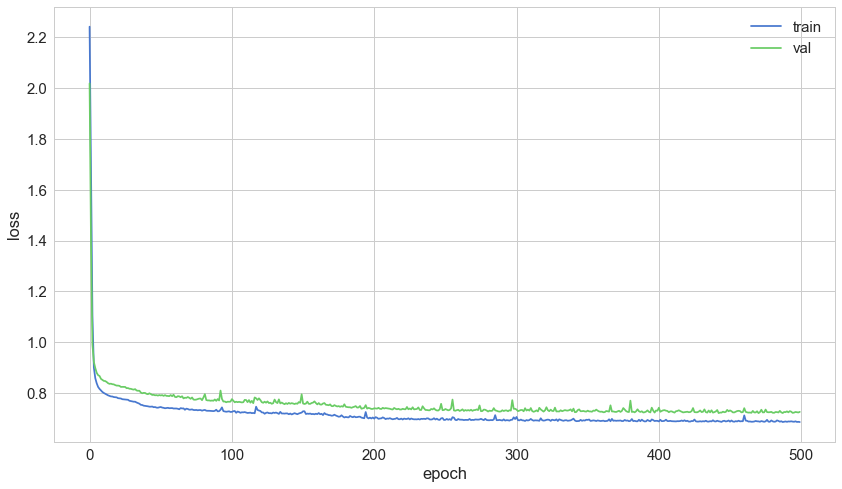

In [128]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper right')

<b>Reconstruction error:</b>
We can compare the reconstructon error for normal transactions and fraudulent transactions.

Nb samples in test: 57355
1259.9275180553952


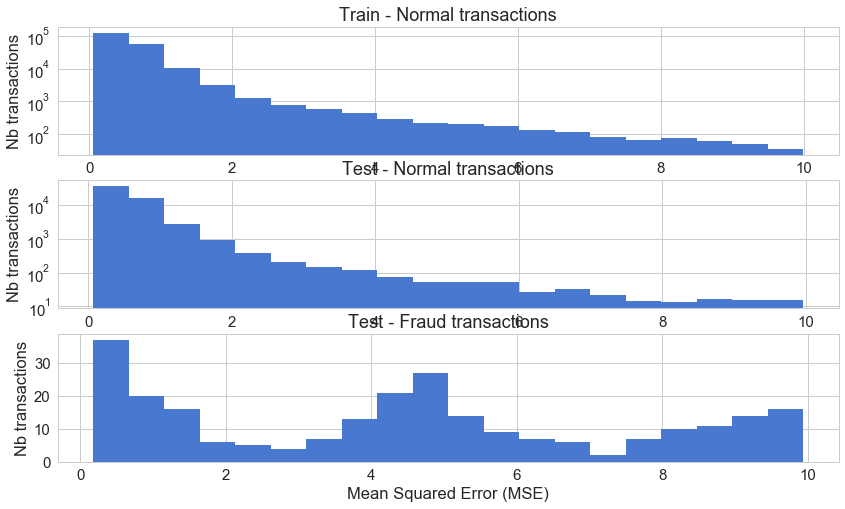

In [227]:
X_train_pred = autoencoder.predict(X_train)
X_test_pred  = autoencoder.predict(X_test) 

train_mse = np.mean(np.power(X_train - X_train_pred, 2), axis =1)
test_mse = np.mean(np.power(X_test - X_test_pred, 2), axis =1)

f, ax = plt.subplots(3,1)
ax[0].hist(train_mse[(train_mse<10)],bins=20)
#ax[0].hist(train_mse,bins=20)
#ax[0].hist(mse[(Y_test==0)],bins=20)
ax[0].set_yscale('log')
ax[0].set_ylabel('Nb transactions')
ax[0].set_title('Train - Normal transactions')
ax[1].hist(test_mse[(Y_test==0) & (test_mse < 10)],bins=20)
ax[1].set_yscale('log')
ax[1].set_ylabel('Nb transactions')
ax[1].set_title('Test - Normal transactions')
ax[2].hist(test_mse[(Y_test==1) & (test_mse < 10)],bins=20)
#ax[2].hist(test_mse[Y_test==1],bins=20)
ax[2].set_ylabel('Nb transactions')
ax[2].set_title('Test - Fraud transactions')
ax[2].set_xlabel('Mean Squared Error (MSE)')

print("Nb samples in test:",len(test_mse))
#print("Nb samples with error MSE less than 10:",np.shape(mse[(Y_test==0) & (mse<10)]))
#print("Nb samples of Fraud transactions:",np.sum(Y_test))
print(np.max(test_mse))

Nb samples in test: 57355
1155.760367721992


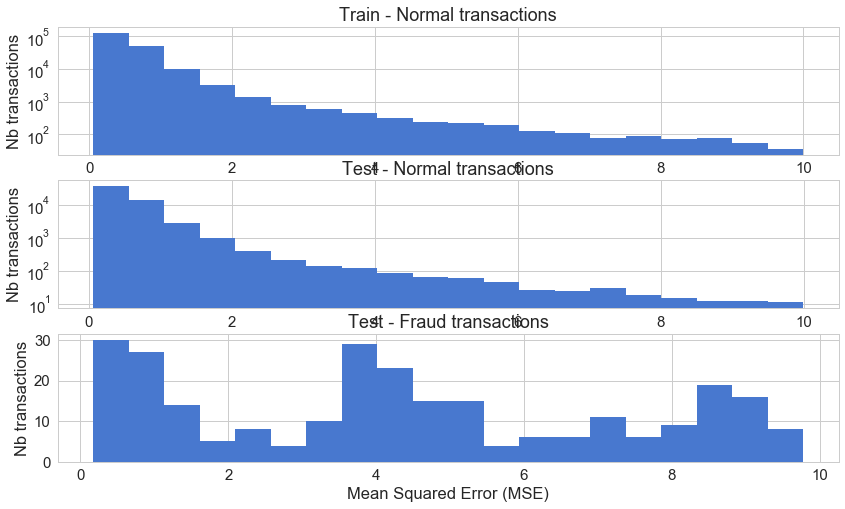

In [228]:
X_train_pred1 = autoencoder1.predict(X_train)
X_test_pred1  = autoencoder1.predict(X_test) 

train_mse1 = np.mean(np.power(X_train - X_train_pred1, 2), axis =1)
test_mse1 = np.mean(np.power(X_test - X_test_pred1, 2), axis =1)

f, ax = plt.subplots(3,1)
ax[0].hist(train_mse1[(train_mse1<10)],bins=20)
#ax[0].hist(train_mse,bins=20)
#ax[0].hist(mse[(Y_test==0)],bins=20)
ax[0].set_yscale('log')
ax[0].set_ylabel('Nb transactions')
ax[0].set_title('Train - Normal transactions')
ax[1].hist(test_mse1[(Y_test==0) & (test_mse1 < 10)],bins=20)
ax[1].set_yscale('log')
ax[1].set_ylabel('Nb transactions')
ax[1].set_title('Test - Normal transactions')
ax[2].hist(test_mse1[(Y_test==1) & (test_mse1 < 10)],bins=20)
#ax[2].hist(test_mse[Y_test==1],bins=20)
ax[2].set_ylabel('Nb transactions')
ax[2].set_title('Test - Fraud transactions')
ax[2].set_xlabel('Mean Squared Error (MSE)')

print("Nb samples in test:",len(test_mse1))
#print("Nb samples with error MSE less than 10:",np.shape(mse[(Y_test==0) & (mse<10)]))
#print("Nb samples of Fraud transactions:",np.sum(Y_test))
print(np.max(test_mse1))

In [229]:
# Setting the threshold from the last figure
threshold = 3.8

for thr in np.arange(3.5,4.5,0.1):
    print("-"*30)
    print("threshold:",thr)
    print("-"*30)
    
    Y_pred = [1 if e > thr else 0 for e in test_mse]
    print("Autoencoder - Confusion matrix:")
    print(confusion_matrix(Y_test,Y_pred))
    print("F1 score:",f1_score(Y_test,Y_pred))
    print("Precision score:",precision_score(Y_test,Y_pred))
    print("Recall score:",recall_score(Y_test,Y_pred))
    print("Average precision score:",average_precision_score(Y_test,Y_pred))

    Y_pred1 = [1 if e > thr else 0 for e in test_mse1]
    print("Autoencoder - Confusion matrix:")
    print(confusion_matrix(Y_test,Y_pred1))
    print("F1 score:",f1_score(Y_test,Y_pred1))
    print("Precision score:",precision_score(Y_test,Y_pred1))
    print("Recall score:",recall_score(Y_test,Y_pred1))
    print("Average precision score:",average_precision_score(Y_test,Y_pred1))

------------------------------
threshold: 3.5
------------------------------
Autoencoder - Confusion matrix:
[[56147   716]
 [   94   398]]
F1 score: 0.4956413449564135
Precision score: 0.35727109515260325
Recall score: 0.8089430894308943
Average precision score: 0.2906508990032152
Autoencoder - Confusion matrix:
[[56113   750]
 [   97   395]]
F1 score: 0.4825901038485034
Precision score: 0.34497816593886466
Recall score: 0.8028455284552846
Average precision score: 0.278655399279495
------------------------------
threshold: 3.6
------------------------------
Autoencoder - Confusion matrix:
[[56171   692]
 [   95   397]]
F1 score: 0.502213788741303
Precision score: 0.36455463728191
Recall score: 0.806910569105691
Average precision score: 0.29581934063692844
Autoencoder - Confusion matrix:
[[56154   709]
 [   98   394]]
F1 score: 0.49404388714733544
Precision score: 0.357207615593835
Recall score: 0.8008130081300813
Average precision score: 0.2877651617829995
----------------------------

<h2>Variational Autoencoder</h2>

In [162]:
batch_size = 2048
original_dim = 29 #X_train.shape[1]
latent_dim = 7 # Number of possible values of the output?
intermediate_dim = 14
epsilon_std = 1.0

def sampling(args):
    '''
        This function is to sample new similar points from the latent
        space.
        Source: blog.keras.io
    '''
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 7),
                              mean=0.0, stddev=1.0)
    #epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
    #                          mean=0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var/2)*epsilon

def get_variatonal_autoencoder_model():
    '''
        This function creates the Variational Autoencoder model plus
        an encoder and a generator models.
        Architecture: 1 hidden layer + 1 output layer
        Source: blog.keras.io
    '''
    
    # ENCODER
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)
    
    # SAMPLING
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean,z_log_var])
    
    # DECODER
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)
    
    # end-to-end Autoencoder
    vae = Model(x,x_decoded_mean)
    
    # ENCODER: from inputs to latent space
    encoder = Model(x,z_mean)
    
    # DECODER: from latent space to reconstructed inputs
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    _x_decoded_mean = decoder_mean(_h_decoded)
    
    generator = Model(decoder_input,_x_decoded_mean)
    
    def vae_loss(x, x_decoded_mean):
        '''
        The loss function is the sum of a reconstruction loss and a KL
        divergence regularization term.
        '''
        # Reconstruction loss
        # Use of the binary crossentropy because there are only two classes
        xent_loss = original_dim*metrics.binary_crossentropy(x,x_decoded_mean)
        # KL divergence loss
        kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
    
        return K.mean(xent_loss + kl_loss)
    
    # Training model
    vae.compile(optimizer='rmsprop',loss=vae_loss)
    vae.summary()
    return vae

In [163]:
nb_epochs = 500

#vae_model = get_variatonal_autoencoder_model()

########################
# ENCODER
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
    
# SAMPLING
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean,z_log_var])
    
# DECODER
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
    
# end-to-end Autoencoder
vae_model = Model(x,x_decoded_mean)
    
# ENCODER: from inputs to latent space
encoder = Model(x,z_mean)
    
# DECODER: from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
    
generator = Model(decoder_input,_x_decoded_mean)
    
def vae_loss(x, x_decoded_mean):
    '''
        The loss function is the sum of a reconstruction loss and a KL
        divergence regularization term.
    '''
    # Reconstruction loss
    # Use of the binary crossentropy because there are only two classes
    xent_loss = original_dim*metrics.binary_crossentropy(x,x_decoded_mean)
    # KL divergence loss
    kl_loss = -0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
    
    return K.mean(xent_loss + kl_loss)
    
# Training model
vae_model.compile(optimizer='rmsprop',loss=vae_loss)
vae_model.summary()


########################

# Defining checkpoints
vae_bestModelFile = 'vae_autoencoder.h5'
vae_checkpoint = ModelCheckpoint(filepath=vae_bestModelFile,verbose=1,
                                 monitor='val_loss',mode='min',
                                 save_best_only=True)
vae_earlystop = EarlyStopping(monitor='val_loss',patience=20,
                              verbose=1,mode='min')

vae_history = vae_model.fit(X_train, X_train, shuffle=True,
                            epochs=nb_epochs, batch_size=batch_size,
                            validation_data=(X_test,X_test), verbose=1,
                            callbacks=[vae_checkpoint,vae_earlystop])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 29)           0                                            
__________________________________________________________________________________________________
dense_89 (Dense)                (None, 14)           420         input_27[0][0]                   
__________________________________________________________________________________________________
dense_90 (Dense)                (None, 7)            105         dense_89[0][0]                   
__________________________________________________________________________________________________
dense_91 (Dense)                (None, 7)            105         dense_89[0][0]                   
__________________________________________________________________________________________________
lambda_9 (

190464/199020 [===========================>..] - ETA: 0s - loss: -75.6995
Epoch 00022: val_loss improved from -78.90042 to -80.26845, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 5us/step - loss: -75.7095 - val_loss: -80.2685
Epoch 23/500
192512/199020 [============================>.] - ETA: 0s - loss: -77.0380
Epoch 00023: val_loss improved from -80.26845 to -81.42196, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 5us/step - loss: -77.0671 - val_loss: -81.4220
Epoch 24/500
198656/199020 [============================>.] - ETA: 0s - loss: -78.2651
Epoch 00024: val_loss improved from -81.42196 to -82.45378, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -78.2664 - val_loss: -82.4538
Epoch 25/500
198656/199020 [============================>.] - ETA: 0s - loss: -79.2896
Epoch 00025: val_loss improved from -82.45378 to -83.42366, saving model to vae_aut

198656/199020 [============================>.] - ETA: 0s - loss: -91.1123
Epoch 00051: val_loss improved from -94.92000 to -95.09855, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -91.1184 - val_loss: -95.0986
Epoch 52/500
198656/199020 [============================>.] - ETA: 0s - loss: -91.2968
Epoch 00052: val_loss improved from -95.09855 to -95.25400, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -91.3090 - val_loss: -95.2540
Epoch 53/500
198656/199020 [============================>.] - ETA: 0s - loss: -91.4730
Epoch 00053: val_loss improved from -95.25400 to -95.46018, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -91.4661 - val_loss: -95.4602
Epoch 54/500
198656/199020 [============================>.] - ETA: 0s - loss: -91.6154
Epoch 00054: val_loss improved from -95.46018 to -95.64740, saving model to vae_aut

Epoch 82/500
198656/199020 [============================>.] - ETA: 0s - loss: -95.3786
Epoch 00082: val_loss improved from -98.85329 to -98.95211, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -95.3796 - val_loss: -98.9521
Epoch 83/500
198656/199020 [============================>.] - ETA: 0s - loss: -95.4689
Epoch 00083: val_loss improved from -98.95211 to -99.28853, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -95.4720 - val_loss: -99.2885
Epoch 84/500
198656/199020 [============================>.] - ETA: 0s - loss: -95.6384
Epoch 00084: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -95.6389 - val_loss: -99.2329
Epoch 85/500
198656/199020 [============================>.] - ETA: 0s - loss: -95.7277
Epoch 00085: val_loss improved from -99.28853 to -99.33177, saving model to vae_autoencoder.h5
199020/199020 [=================

Epoch 114/500
190464/199020 [===========================>..] - ETA: 0s - loss: -98.8617
Epoch 00114: val_loss did not improve
199020/199020 [==============================] - 1s 5us/step - loss: -98.8452 - val_loss: -101.4315
Epoch 115/500
192512/199020 [============================>.] - ETA: 0s - loss: -98.9245
Epoch 00115: val_loss did not improve
199020/199020 [==============================] - 1s 5us/step - loss: -98.9134 - val_loss: -101.3489
Epoch 116/500
190464/199020 [===========================>..] - ETA: 0s - loss: -98.9372
Epoch 00116: val_loss improved from -101.58764 to -101.62441, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 5us/step - loss: -99.0114 - val_loss: -101.6244
Epoch 117/500
192512/199020 [============================>.] - ETA: 0s - loss: -99.0731
Epoch 00117: val_loss did not improve
199020/199020 [==============================] - 1s 5us/step - loss: -99.0368 - val_loss: -101.4261
Epoch 118/500
192512/199020 [========

198656/199020 [============================>.] - ETA: 0s - loss: -100.2722
Epoch 00147: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -100.2733 - val_loss: -102.7225
Epoch 148/500
198656/199020 [============================>.] - ETA: 0s - loss: -100.2937
Epoch 00148: val_loss improved from -102.80364 to -102.80371, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -100.2968 - val_loss: -102.8037
Epoch 149/500
198656/199020 [============================>.] - ETA: 0s - loss: -100.3188
Epoch 00149: val_loss improved from -102.80371 to -102.84222, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -100.3362 - val_loss: -102.8422
Epoch 150/500
198656/199020 [============================>.] - ETA: 0s - loss: -100.3395
Epoch 00150: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -100.3437 - val_

188416/199020 [===========================>..] - ETA: 0s - loss: -101.1888
Epoch 00180: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -101.2146 - val_loss: -103.4455
Epoch 181/500
192512/199020 [============================>.] - ETA: 0s - loss: -101.2607
Epoch 00181: val_loss improved from -103.44648 to -103.49966, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -101.2619 - val_loss: -103.4997
Epoch 182/500
186368/199020 [===========================>..] - ETA: 0s - loss: -101.2739
Epoch 00182: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -101.2814 - val_loss: -103.3097
Epoch 183/500
190464/199020 [===========================>..] - ETA: 0s - loss: -101.3130
Epoch 00183: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -101.3000 - val_loss: -103.4218
Epoch 184/500
188416/199020 [==============

Epoch 214/500
198656/199020 [============================>.] - ETA: 0s - loss: -102.5503
Epoch 00214: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -102.5485 - val_loss: -103.8894
Epoch 215/500
198656/199020 [============================>.] - ETA: 0s - loss: -102.6159
Epoch 00215: val_loss improved from -103.98339 to -104.23950, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -102.6299 - val_loss: -104.2395
Epoch 216/500
196608/199020 [============================>.] - ETA: 0s - loss: -102.6433
Epoch 00216: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -102.6609 - val_loss: -103.9387
Epoch 217/500
196608/199020 [============================>.] - ETA: 0s - loss: -102.7436
Epoch 00217: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -102.7484 - val_loss: -104.2154
Epoch 218/500
194560/199020 [

Epoch 244/500
196608/199020 [============================>.] - ETA: 0s - loss: -104.0932
Epoch 00244: val_loss improved from -106.10081 to -106.13420, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -104.1016 - val_loss: -106.1342
Epoch 245/500
198656/199020 [============================>.] - ETA: 0s - loss: -104.1526
Epoch 00245: val_loss improved from -106.13420 to -106.18582, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -104.1565 - val_loss: -106.1858
Epoch 246/500
198656/199020 [============================>.] - ETA: 0s - loss: -104.2037
Epoch 00246: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -104.1892 - val_loss: -106.1836
Epoch 247/500
198656/199020 [============================>.] - ETA: 0s - loss: -104.2436
Epoch 00247: val_loss improved from -106.18582 to -106.22241, saving model to vae_autoencoder.h5
199020/19902

194560/199020 [============================>.] - ETA: 0s - loss: -105.5335
Epoch 00275: val_loss improved from -107.26431 to -107.26971, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -105.5456 - val_loss: -107.2697
Epoch 276/500
188416/199020 [===========================>..] - ETA: 0s - loss: -105.6420
Epoch 00276: val_loss improved from -107.26971 to -107.38317, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -105.6277 - val_loss: -107.3832
Epoch 277/500
190464/199020 [===========================>..] - ETA: 0s - loss: -105.5448
Epoch 00277: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -105.6514 - val_loss: -107.2923
Epoch 278/500
188416/199020 [===========================>..] - ETA: 0s - loss: -105.7082
Epoch 00278: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -105.6585 - val_

Epoch 306/500
186368/199020 [===========================>..] - ETA: 0s - loss: -106.9086
Epoch 00306: val_loss improved from -108.77116 to -108.79351, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 4us/step - loss: -106.8804 - val_loss: -108.7935
Epoch 307/500
196608/199020 [============================>.] - ETA: 0s - loss: -106.9313
Epoch 00307: val_loss improved from -108.79351 to -108.94092, saving model to vae_autoencoder.h5
199020/199020 [==============================] - 1s 5us/step - loss: -106.9307 - val_loss: -108.9409
Epoch 308/500
186368/199020 [===========================>..] - ETA: 0s - loss: -106.9105
Epoch 00308: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -106.9481 - val_loss: -108.8120
Epoch 309/500
194560/199020 [============================>.] - ETA: 0s - loss: -107.0024
Epoch 00309: val_loss improved from -108.94092 to -108.98306, saving model to vae_autoencoder.h5
199020/19902

Epoch 340/500
192512/199020 [============================>.] - ETA: 0s - loss: -107.7814
Epoch 00340: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -107.8108 - val_loss: -109.1104
Epoch 341/500
196608/199020 [============================>.] - ETA: 0s - loss: -107.7872
Epoch 00341: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -107.8092 - val_loss: -109.2570
Epoch 342/500
198656/199020 [============================>.] - ETA: 0s - loss: -107.8232
Epoch 00342: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -107.8060 - val_loss: -109.5178
Epoch 343/500
188416/199020 [===========================>..] - ETA: 0s - loss: -107.8615
Epoch 00343: val_loss did not improve
199020/199020 [==============================] - 1s 4us/step - loss: -107.8542 - val_loss: -109.3642
Epoch 344/500
198656/199020 [============================>.] - ETA: 0s - loss: -107.8540

In [164]:
#vae_model = load_model(vae_bestModelFile)
#X_pred_vae = vae_model.predict(X_test)
vae_model.load_weights(vae_bestModelFile)

Nb samples in test: 56962
1623.267230591922


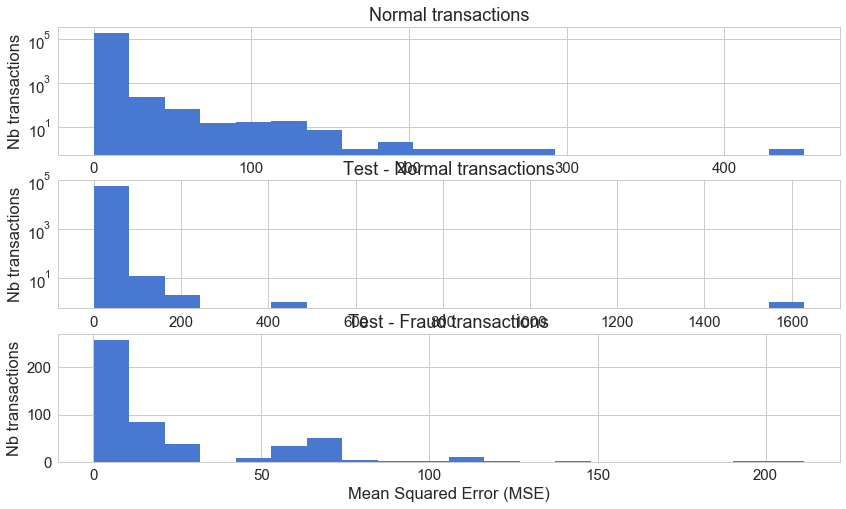

In [165]:
X_train_pred_vae = vae_model.predict(X_train)
X_test_pred_vae = vae_model.predict(X_test)

train_mse_vae = np.mean(np.power(X_train - X_train_pred_vae, 2), axis =1)
test_mse_vae = np.mean(np.power(X_test - X_test_pred_vae, 2), axis =1)

f, ax = plt.subplots(3,1)
#ax[0].hist(mse_vae[(Y_test==0) & (mse_vae<10)],bins=20)
ax[0].hist(train_mse_vae,bins=20)
#ax[0].hist(mse_vae[(Y_test==0)],bins=20)
ax[0].set_yscale('log')
ax[0].set_ylabel('Nb transactions')
ax[0].set_title('Normal transactions')
ax[1].hist(test_mse_vae[Y_test==0],bins=20)
ax[1].set_yscale('log')
ax[1].set_ylabel('Nb transactions')
ax[1].set_title('Test - Normal transactions')
ax[2].hist(test_mse_vae[Y_test==1],bins=20)
ax[2].set_ylabel('Nb transactions')
ax[2].set_title('Test - Fraud transactions')
ax[2].set_xlabel('Mean Squared Error (MSE)')

print("Nb samples in test:",len(mse_vae))
#print("Nb samples with error MSE less than 10:",np.shape(mse[(Y_test==0) & (mse<10)]))
#print("Nb samples of Fraud transactions:",np.sum(Y_test))
print(np.max(mse_vae))

In [171]:
# Setting the threshold from the last figure
threshold = 4.5
Y_pred_vae = [1 if e > threshold else 0 for e in test_mse_vae]
print(confusion_matrix(Y_test,Y_pred_vae))
print(f1_score(Y_test,Y_pred_vae))

[[56066   797]
 [  110   382]]
0.457211250748055
